In [1]:
#Imports
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
#from hvplot import hvplot
#import hvplot.pandas

In [164]:
#Function to pull in stock data
def stock_data(ticker, start_date, end_date, drop_extra_cols = True):
    try:
        # get ticker object
        ticker_data = yf.Ticker(ticker)
        # fetch data between start date ane end date
        df = ticker_data.history(start=start_date, end=end_date)
        # Drop unnecessary columns
        if len(df) > 0 and drop_extra_cols:
            df = df.drop(["Open", "High", "Low", "Volume", "Dividends", "Stock Splits" ], axis=1)
        return df
    
    except Exception as e:
        print(f"ERROR: An Error occurred while fetching and formatting data for {ticker} from yfinance  \n DETAILS: {repr(e)}")
        raise
        

In [206]:
#Get stock data 
# Calculate daily return 
# Generate trading signals, when daily return > 0 that's a buy signal or 1 and when daily return < 0 that's a sell 
#signal or 0
# rolling window should equal the window size 
window = 5
start_date = "2010-01-01"
end_date = "2017-12-31"
ticker = "MSFT"
ticker_df = stock_data(ticker, start_date, end_date, drop_extra_cols = True)

ticker_df["Daily Return"] = ticker_df["Close"].pct_change().dropna()
#ticker_df["Rolling Std Dev"] = ticker_df["Daily Return"].rolling(window = window).std()
#ticker_df["Trading Signal"] = 0.0
#ticker_df["Trading Signal"] = np.where(
    #ticker_df["Daily Return"] > 0, 1.0, 0
#)
#ticker_df["Entry/Exit"] = ticker_df["Trading Signal"].diff()
ticker_df.dropna(inplace=True)
ticker_df.head()

,Close,Daily Return
Date,,
2010-01-05,24.002319,0.000323
2010-01-06,23.855013,-0.006137
2010-01-07,23.606922,-0.010400
2010-01-08,23.769743,0.006897
2010-01-11,23.467388,-0.012720


In [207]:
ticker_df.head(20)

,Close,Daily Return
Date,,
2010-01-05,24.002319,0.000323
2010-01-06,23.855013,-0.006137
2010-01-07,23.606922,-0.010400
2010-01-08,23.769743,0.006897
2010-01-11,23.467388,-0.012720
2010-01-12,23.312330,-0.006607
2010-01-13,23.529409,0.009312
2010-01-14,24.002319,0.020099
2010-01-15,23.924789,-0.003230


In [208]:
#Function that returns numpy array for X and y
def window_data(df, window, feature_col_number, target_col_number):
    
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [209]:
# Creating the features (X) and target (y) data using the window_data() function.
# Here we are using previous returns to predict future returns 
window_size = window

feature_column = 1
target_column = 1
X, y = window_data(ticker_df, window_size, feature_column, target_column)
#print (f"X sample values:\n{X[:5]} \n")
#print (f"y sample values:\n{y[:5]}")

In [210]:
#split the data into training data and testing data
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [211]:
# Scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [212]:
# Reshape the features into a vertical vector so they work for the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#print (f"X_train sample values:\n{X_train[:5]} \n")
#print (f"X_test sample values:\n{X_test[:5]}")

In [213]:
#Import the models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [214]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
#number of units should equal the window size
number_units = window
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [215]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [216]:
# Show the model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_44 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_45 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_46 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 5)               

In [217]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
16/16 [==============================] - 4s 7ms/step - loss: 0.2409
Epoch 2/10
16/16 [==============================] - 0s 6ms/step - loss: 0.1605
Epoch 3/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0765
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0236
Epoch 5/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 6/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0192
Epoch 7/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0181
Epoch 8/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 9/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0171
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0171


In [218]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.004315291531383991

In [219]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [220]:
# Recover the original returns instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [221]:
#ticker_df["Entry/Exit"] = ticker_df["Trading Signal"].diff()
# Create a DataFrame of Real and Predicted values
actual_trading_signal = np.where(
    real_prices.ravel() > 0, 1.0, 0
)
predicted_trading_signal = np.where(
    predicted_prices.ravel() > 0, 1.0, 0
)
stocks = pd.DataFrame({
    "Actual Return": real_prices.ravel(),
    "Predicted Return": predicted_prices.ravel(),
    "Actual Trading Signal": actual_trading_signal,
    "Predicted Trading Signal": predicted_trading_signal,
 }, index = ticker_df.index[-len(real_prices): ]) 

stocks["Actual Entry/Exit"] = stocks["Actual Trading Signal"].diff()
stocks["Predicted Entry/Exit"] = stocks["Predicted Trading Signal"].diff()
stocks = stocks.dropna()
# Show the DataFrame's head
stocks.head(10)

,Actual Return,Predicted Return,Actual Trading Signal,Predicted Trading Signal,Actual Entry/Exit,Predicted Entry/Exit
Date,,,,,,
2015-08-12,0.007111,-0.004279,1.0,0.0,1.0,0.0
2015-08-13,-0.000214,-0.004625,0.0,0.0,-1.0,0.0
2015-08-14,0.005778,-0.003499,1.0,0.0,1.0,0.0
2015-08-17,0.006808,-0.003614,1.0,0.0,0.0,0.0
2015-08-18,0.005531,-0.004480,1.0,0.0,0.0,0.0
2015-08-19,-0.013962,-0.003235,0.0,0.0,-1.0,0.0
2015-08-20,-0.020382,-0.003437,0.0,0.0,0.0,0.0
2015-08-21,-0.056723,-0.003267,0.0,0.0,0.0,0.0
2015-08-24,-0.032273,-0.003717,0.0,0.0,0.0,0.0


In [222]:
stocks.shape

(602, 6)

In [223]:
stocks

,Actual Return,Predicted Return,Actual Trading Signal,Predicted Trading Signal,Actual Entry/Exit,Predicted Entry/Exit
Date,,,,,,
2015-08-12,0.007111,-0.004279,1.0,0.0,1.0,0.0
2015-08-13,-0.000214,-0.004625,0.0,0.0,-1.0,0.0
2015-08-14,0.005778,-0.003499,1.0,0.0,1.0,0.0
2015-08-17,0.006808,-0.003614,1.0,0.0,0.0,0.0
2015-08-18,0.005531,-0.004480,1.0,0.0,0.0,0.0
2015-08-19,-0.013962,-0.003235,0.0,0.0,-1.0,0.0
2015-08-20,-0.020382,-0.003437,0.0,0.0,0.0,0.0
2015-08-21,-0.056723,-0.003267,0.0,0.0,0.0,0.0
2015-08-24,-0.032273,-0.003717,0.0,0.0,0.0,0.0


In [227]:
stocks.loc['2015-10-29']

Actual Return              -0.011486
Predicted Return            0.000523
Actual Trading Signal       0.000000
Predicted Trading Signal    1.000000
Actual Entry/Exit          -1.000000
Predicted Entry/Exit        1.000000
Name: 2015-10-29 00:00:00, dtype: float64

In [224]:
#export to csv
stocks.to_csv("lstm_daily_return.csv")

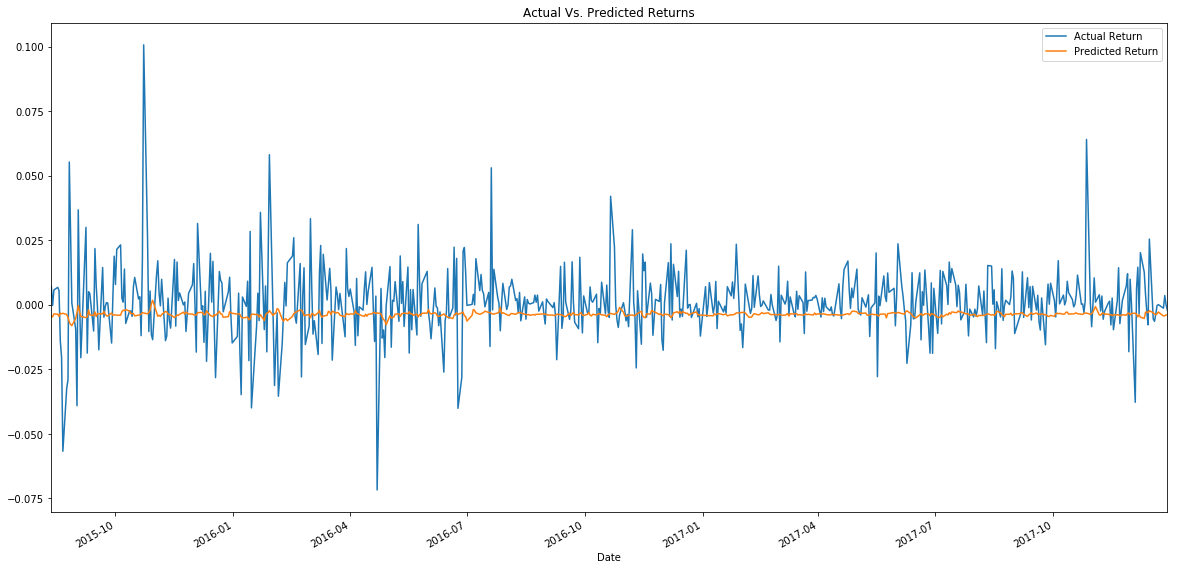

In [225]:
# Plot real returns vs predicted returns 
#Using previous returns to predict future returns
stocks[["Actual Return", "Predicted Return"]].plot(title="Actual Vs. Predicted Returns", figsize=(20,10))

##Reuse the data and functions to analyze rolling standard deviations ability to predict returns

In [305]:
#Get stock data 
# Calculate daily return and rolling standard deviation
# Generate trading signals, when daily return > 0 that's a buy signal or 1 and when daily return < 0 that's a sell 
#signal or 0
# rolling window should equal the window size 
window = 5
start_date = "2010-01-01"
end_date = "2017-12-31"
ticker = "MSFT"
ticker_df = stock_data(ticker, start_date, end_date, drop_extra_cols = True)

ticker_df["Daily Return"] = ticker_df["Close"].pct_change().dropna()
ticker_df["Rolling Std Dev"] = ticker_df["Daily Return"].rolling(window = window).std().shift()
#ticker_df["Trading Signal"] = 0.0
#ticker_df["Trading Signal"] = np.where(
 #   ticker_df["Daily Return"] > 0, 1.0, 0
#)
#ticker_df["Entry/Exit"] = ticker_df["Trading Signal"].diff()
ticker_df.dropna(inplace=True)
ticker_df.head()

,Close,Daily Return,Rolling Std Dev
Date,,,
2010-01-12,23.312330,-0.006607,0.008034
2010-01-13,23.529409,0.009312,0.007600
2010-01-14,24.002319,0.020099,0.010141
2010-01-15,23.924789,-0.003230,0.013096
2010-01-19,24.110857,0.007777,0.013202


In [306]:
# Creating the features (X) and target (y) data using the window_data() function.
# Here we are using rolling standard deviations of daily returns to predict future returns 

window_size = window

feature_column = 2
target_column = 1
X, y = window_data(ticker_df, window_size, feature_column, target_column)
#print (f"X sample values:\n{X[:5]} \n")
#print (f"y sample values:\n{y[:5]}")

In [307]:
#split the data into training data and testing data
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [308]:
# Scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [309]:
# Reshape the features into a vertical vector so they work for the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#print (f"X_train sample values:\n{X_train[:5]} \n")
#print (f"X_test sample values:\n{X_test[:5]}")

In [310]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
#number of units should equal the window size
number_units = window
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [311]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [312]:
# Show the model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_68 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_69 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_70 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_70 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 5)               

In [313]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
16/16 [==============================] - 4s 8ms/step - loss: 0.2544
Epoch 2/10
16/16 [==============================] - 0s 6ms/step - loss: 0.1976
Epoch 3/10
16/16 [==============================] - 0s 6ms/step - loss: 0.1282
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0565
Epoch 5/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0262
Epoch 6/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0259
Epoch 7/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0230
Epoch 8/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0224
Epoch 9/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0205
Epoch 10/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0194


In [314]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.00502733001485467

In [315]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [316]:
# Recover the original returns instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [317]:
# Create a DataFrame of Real and Predicted values 

actual_trading_signal = np.where(
    real_prices.ravel() > 0, 1.0, 0
)
predicted_trading_signal = np.where(
    predicted_prices.ravel() > 0, 1.0, 0
)
std_dev = pd.DataFrame({
    "Actual Return": real_prices.ravel(),
    "Predicted Return": predicted_prices.ravel(),
    "Actual Trading Signal": actual_trading_signal,
    "Predicted Trading Signal": predicted_trading_signal,
 }, index = ticker_df.index[-len(real_prices): ]) 

std_dev["Actual Entry/Exit"] = std_dev["Actual Trading Signal"].diff()
std_dev["Predicted Entry/Exit"] = std_dev["Predicted Trading Signal"].diff()
std_dev = std_dev.dropna()
# Show the DataFrame's head
std_dev.head(10)

,Actual Return,Predicted Return,Actual Trading Signal,Predicted Trading Signal,Actual Entry/Exit,Predicted Entry/Exit
Date,,,,,,
2015-08-14,0.005778,-0.005553,1.0,0.0,1.0,0.0
2015-08-17,0.006808,-0.005432,1.0,0.0,0.0,0.0
2015-08-18,0.005531,-0.005274,1.0,0.0,0.0,0.0
2015-08-19,-0.013962,-0.005314,0.0,0.0,-1.0,0.0
2015-08-20,-0.020382,-0.005578,0.0,0.0,0.0,0.0
2015-08-21,-0.056723,-0.006217,0.0,0.0,0.0,0.0
2015-08-24,-0.032273,-0.006570,0.0,0.0,0.0,0.0
2015-08-25,-0.029030,-0.006966,0.0,0.0,0.0,0.0
2015-08-26,0.055349,-0.007036,1.0,0.0,1.0,0.0


In [318]:
std_dev.tail(10)

,Actual Return,Predicted Return,Actual Trading Signal,Predicted Trading Signal,Actual Entry/Exit,Predicted Entry/Exit
Date,,,,,,
2017-12-15,0.025505,-0.004240,1.0,0.0,1.0,0.0
2017-12-18,-0.005412,-0.005043,0.0,0.0,-1.0,0.0
2017-12-19,-0.006367,-0.006700,0.0,0.0,0.0,0.0
2017-12-20,-0.003612,-0.006467,0.0,0.0,0.0,0.0
2017-12-21,-0.000234,-0.006135,0.0,0.0,0.0,0.0
2017-12-22,0.000117,-0.005789,1.0,0.0,1.0,0.0
2017-12-26,-0.001286,-0.005495,0.0,0.0,-1.0,0.0
2017-12-27,0.003630,-0.005511,1.0,0.0,1.0,0.0
2017-12-28,0.000117,-0.005767,1.0,0.0,0.0,0.0


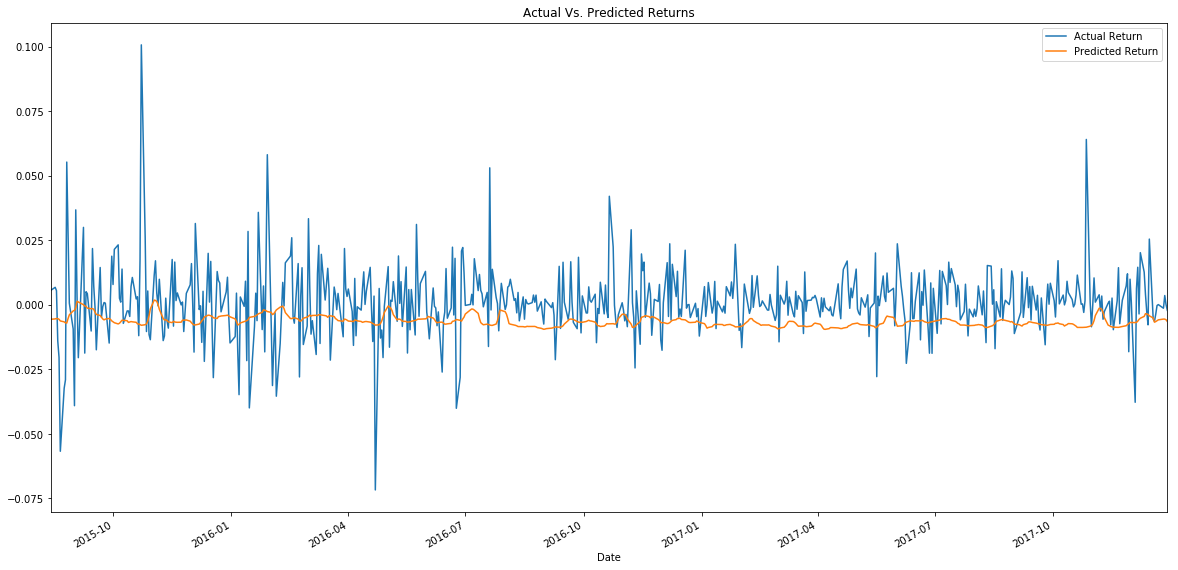

In [319]:
# Plot real returns vs predicted returns 
# Using rolling standard deviations of daily returns to predict future returns
std_dev[["Actual Return", "Predicted Return"]].plot(title="Actual Vs. Predicted Returns", figsize=(20,10))

In [320]:
#Export to csv
std_dev.to_csv("lstm_standard_dev_and_returns.csv")

In [ ]:
#Is there a way to combine rolling standard deviations and price predictions to get at predicted returns 
#to then compare them to actual returns

# Use rolling standard deviations to predict closing prices and compare those daily returns to actual daily returns 

In [321]:
# Creating the features (X) and target (y) data using the window_data() function.
# Here we are using rolling standard deviations of daily returns to predict future prices and then calculating the
# of predicted future price to actual prices
#Get stock data 
# rolling window should equal the window size 
window = 5
start_date = "2010-01-01"
end_date = "2017-12-31"
ticker = "MSFT"
ticker_df = stock_data(ticker, start_date, end_date, drop_extra_cols = True)

ticker_df["Daily Return"] = ticker_df["Close"].pct_change().dropna()
ticker_df["Rolling Std Dev"] = ticker_df["Daily Return"].rolling(window = window).std().shift()
#ticker_df["Trading Signal"] = 0.0
#ticker_df["Trading Signal"] = np.where(
 #   ticker_df["Daily Return"] > 0, 1.0, 0
#)
#ticker_df["Entry/Exit"] = ticker_df["Trading Signal"].diff()
ticker_df.dropna(inplace=True)
ticker_df.head()

,Close,Daily Return,Rolling Std Dev
Date,,,
2010-01-12,23.312330,-0.006607,0.008034
2010-01-13,23.529409,0.009312,0.007600
2010-01-14,24.002319,0.020099,0.010141
2010-01-15,23.924789,-0.003230,0.013096
2010-01-19,24.110857,0.007777,0.013202


In [322]:
# Creating the features (X) and target (y) data using the window_data() function.
# Here we are using rolling standard deviations of daily returns to predict future prices 

window_size = window

feature_column = 2
target_column = 0
X, y = window_data(ticker_df, window_size, feature_column, target_column)
#print (f"X sample values:\n{X[:5]} \n")
#print (f"y sample values:\n{y[:5]}")

In [323]:
#split the data into training data and testing data
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [324]:
# Scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [326]:
# Reshape the features into a vertical vector so they work for the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#print (f"X_train sample values:\n{X_train[:5]} \n")
#print (f"X_test sample values:\n{X_test[:5]}")

In [328]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
#number of units should equal the window size
number_units = window
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [329]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [330]:
# Show the model summary
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_72 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_73 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_73 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_74 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_74 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_75 (LSTM)               (None, 5)               

In [331]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
16/16 [==============================] - 4s 7ms/step - loss: 0.0249
Epoch 2/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0157
Epoch 3/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0136
Epoch 4/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0148
Epoch 5/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0154
Epoch 6/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0148
Epoch 7/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0147
Epoch 8/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0148
Epoch 9/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0147
Epoch 10/10
16/16 [==============================] - 0s 6ms/step - loss: 0.0144


In [332]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.2334890216588974

In [333]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [334]:
# Recover the original returns instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [344]:
# Create a DataFrame of Real and Predicted values
std_dev_prices = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = ticker_df.index[-len(real_prices): ]) 

std_dev_prices["Actual Return"] = std_dev_prices["Actual"].pct_change()
std_dev_prices["Predicted Return"] = std_dev_prices["Predicted"].pct_change()
std_dev_prices["Actual Trading Signal"] = np.where(
   std_dev_prices["Actual Return"] > 0, 1.0, 0 
)

std_dev_prices["Predicted Trading Signal"] = np.where(
    std_dev_prices["Predicted Return"] > 0, 1.0, 0
)
std_dev_prices["Actual Entry/Exit"] = std_dev_prices["Actual Trading Signal"].diff()
std_dev_prices["Predicted Entry/Exit"] = std_dev_prices["Predicted Trading Signal"].diff()
std_dev_prices = std_dev_prices.dropna()

# Show the DataFrame's head
std_dev_prices.head(10)

,Actual,Predicted,Actual Return,Predicted Return,Actual Trading Signal,Predicted Trading Signal,Actual Entry/Exit,Predicted Entry/Exit
Date,,,,,,,,
2015-08-14,42.128227,27.827291,0.005778,0.002559,1.0,1.0,1.0,1.0
2015-08-17,42.415047,27.840637,0.006808,0.000480,1.0,1.0,0.0,0.0
2015-08-18,42.649643,27.855247,0.005531,0.000525,1.0,1.0,0.0,0.0
2015-08-19,42.054153,27.848328,-0.013962,-0.000248,0.0,0.0,-1.0,-1.0
2015-08-20,41.197006,27.816114,-0.020382,-0.001157,0.0,0.0,0.0,0.0
2015-08-21,38.860176,27.746244,-0.056723,-0.002512,0.0,0.0,0.0,0.0
2015-08-24,37.606030,27.707111,-0.032273,-0.001410,0.0,0.0,0.0,0.0
2015-08-25,36.514309,27.675581,-0.029030,-0.001138,0.0,0.0,0.0,0.0
2015-08-26,38.535351,27.691292,0.055349,0.000568,1.0,1.0,1.0,1.0


In [345]:
std_dev_prices.tail(10)

,Actual,Predicted,Actual Return,Predicted Return,Actual Trading Signal,Predicted Trading Signal,Actual Entry/Exit,Predicted Entry/Exit
Date,,,,,,,,
2017-12-15,82.863663,27.959450,0.025505,-0.002412,1.0,0.0,1.0,0.0
2017-12-18,82.415230,27.869194,-0.005412,-0.003228,0.0,0.0,-1.0,0.0
2017-12-19,81.890480,27.702126,-0.006367,-0.005995,0.0,0.0,0.0,0.0
2017-12-20,81.594727,27.729055,-0.003612,0.000972,0.0,1.0,0.0,1.0
2017-12-21,81.575638,27.765709,-0.000234,0.001322,0.0,1.0,0.0,0.0
2017-12-22,81.585175,27.802637,0.000117,0.001330,1.0,1.0,1.0,0.0
2017-12-26,81.480217,27.832533,-0.001286,0.001075,0.0,1.0,-1.0,0.0
2017-12-27,81.775978,27.827847,0.003630,-0.000168,1.0,0.0,1.0,-1.0
2017-12-28,81.785538,27.793715,0.000117,-0.001227,1.0,0.0,0.0,0.0


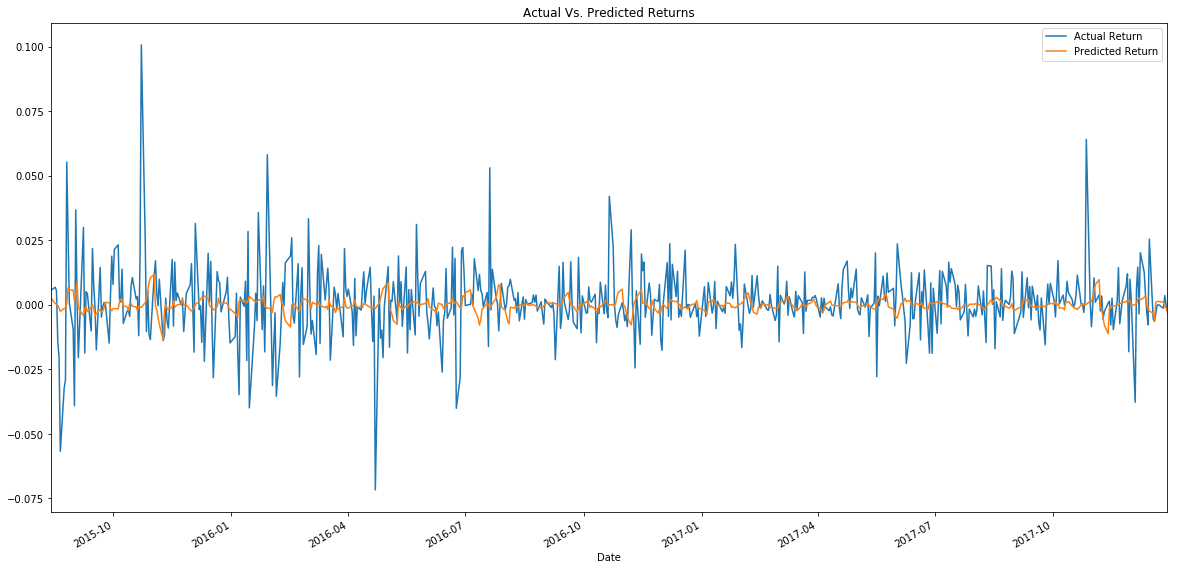

In [346]:
# Plot real returns vs predicted returns 
# Using rolling standard deviations of daily returns to predict future returns
std_dev_prices[["Actual Return", "Predicted Return"]].plot(title="Actual Vs. Predicted Returns", figsize=(20,10))

In [347]:
#Export to csv
std_dev_prices.to_csv("lstm_standard_dev_prices_returns.csv")